# Phase 3 project

## Covid Dataset

In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostRegressor

from colorama import Fore
from colorama import Style

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_covid=pd.read_csv('Covid Data.csv')

In [3]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


### Description of Dataset

About Dataset
Context
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

### content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [4]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

The column 'CLASSIFICATION_FINAL' tells us which patients tested positive for Covid and which ones didn't.
Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive. 
So since we are interested only in data regarding covid positive patients, we will filter out the rows that have a value greater than 3.

In [5]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

7    0.476122
3    0.363853
6    0.122197
5    0.024882
1    0.008203
4    0.002977
2    0.001765
Name: CLASIFFICATION_FINAL, dtype: float64

In [6]:
df_covid.drop(df_covid.loc[df_covid['CLASIFFICATION_FINAL']>3].index, inplace=True)

In [7]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

3    0.973335
1    0.021943
2    0.004722
Name: CLASIFFICATION_FINAL, dtype: float64

In [8]:
df_covid.shape

(391979, 21)

We still have a good amount of entries left.
And now that we made sure our dataframe contains only covid positive patients, I need to decide which one should be the target variable. <br>The possible ones are:'patient type', 'usmr', 'medical unit', 'icu', 'date died'

In [9]:
### ADD MARKDOWN to describe the columns

In [10]:
df_covid['USMER'].value_counts(normalize=True)

2    0.624658
1    0.375342
Name: USMER, dtype: float64

In [11]:
df_covid['PATIENT_TYPE'].value_counts(normalize=True)

1    0.716077
2    0.283923
Name: PATIENT_TYPE, dtype: float64

In [12]:
### This could be good but it is imbalanced. But maybe even like this it is ok.

In [13]:
df_covid['MEDICAL_UNIT'].value_counts(normalize=True)

12    0.531217
4     0.323101
6     0.045125
9     0.037209
3     0.022019
8     0.012740
10    0.009712
11    0.009529
5     0.007278
7     0.001056
13    0.000880
1     0.000102
2     0.000031
Name: MEDICAL_UNIT, dtype: float64

In [14]:
# Not very informative

In [15]:
df_covid['ICU'].value_counts(normalize=True)

97    0.716077
2     0.253386
1     0.026657
99    0.003880
Name: ICU, dtype: float64

In [16]:
# Mostly missing values

In [17]:
df_covid['DATE_DIED'].value_counts(normalize=True)

9999-99-99    0.861635
13/07/2020    0.002008
06/07/2020    0.001972
16/07/2020    0.001941
07/07/2020    0.001934
                ...   
30/10/2020    0.000003
20/03/2020    0.000003
23/11/2020    0.000003
10/03/2021    0.000003
10/02/2021    0.000003
Name: DATE_DIED, Length: 288, dtype: float64

In [18]:
# Mostly missing values

Stays standing 'classification', 'patient type'

To make the decision between these two variables we did some research to gain some domain knowledge and spoke directly to some first responders during the covid 19 pandemic, that suggested that the information about whether or not a patient needed to be hospitalized was more valuable than the results of the covid test.
This is the case since some patients might have tested positive for covid 19, but because of mild symptoms and overall good health were sent back home to be treated, and what actually really put a strain on health structures was the number of people in need to be hospitalized. Because of this we are going to use 'patient type' as our target for this study.
We are also going to drop all the other variables related to hospitalization since those contain knowledge about the hospitalization of the patient, while what we are trying to predict is the amout of people that would need to be hospitalized, based on previous knowledge so this is not a type of information we would have, if we wanted to use the model again on other data.

So target should be patient type and all the other hospital related variables should be dropped.

In [19]:
df=df_covid.drop(['USMER', 'MEDICAL_UNIT', 'INTUBED', 'CLASIFFICATION_FINAL', 'ICU', 'DATE_DIED'], axis=1)

In [20]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2
2,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2
4,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2
5,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2
6,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,2,2,77,2,1,2,2,1,1,2,2,2,2,2
1047934,1,1,2,55,2,1,2,2,2,2,2,2,2,2,2
1047935,2,1,2,70,97,2,2,2,2,1,2,2,2,2,2
1047936,2,1,2,32,97,2,2,2,2,2,2,2,2,2,2


The missing values are catalogued as 97 or 99. So I have to look for these values to understand how many null values.

Will need to find a way to replace the missing values for pregnant.

In [21]:
for i in df.columns:
    print(df[i].value_counts(normalize=True))
    print("\n")

2    0.534439
1    0.465561
Name: SEX, dtype: float64


1    0.716077
2    0.283923
Name: PATIENT_TYPE, dtype: float64


2     0.780486
1     0.219504
99    0.000010
Name: PNEUMONIA, dtype: float64


37     0.023009
45     0.022769
40     0.022728
30     0.022703
46     0.022682
         ...   
119    0.000003
104    0.000003
116    0.000003
106    0.000003
120    0.000003
Name: AGE, Length: 110, dtype: float64


97    0.534439
2     0.455007
1     0.007026
98    0.003528
Name: PREGNANT, dtype: float64


2     0.837864
1     0.158463
98    0.003674
Name: DIABETES, dtype: float64


2     0.981009
1     0.015641
98    0.003350
Name: COPD, dtype: float64


2     0.970098
1     0.026563
98    0.003339
Name: ASTHMA, dtype: float64


2     0.984127
1     0.012177
98    0.003697
Name: INMSUPR, dtype: float64


2     0.800716
1     0.195743
98    0.003541
Name: HIPERTENSION, dtype: float64


2     0.968993
1     0.025557
98    0.005449
Name: OTHER_DISEASE, dtype: float64


2     0.974751
1    

97, 98 and 99 represent missing values for all the columns except 'AGE'.
<br>For some categories the missing values are so little that it's worth just dropping them. <br>For the two categories with the most missing values, 'PREGNANT' and 'PNEUMONIA' we will proceed to impute them.

We will temporarily remove the 'age' column as in this one 97, 98 and 99 are actually real values and not missing values.
<br> We will work on this column first to remove the outliers, then we will drop it from the dataset and reeinsert it once we dealt with the missing values for the other columns.

In [22]:
age=df['AGE']

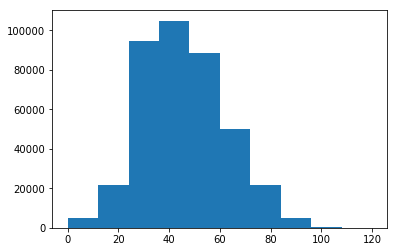

In [23]:
plt.hist(age);

Even if we cannot be certain about this, since there is no information about this on the dataset, we can safely assume that values for age that are above 110 are probably typos or outliers. It might also be the way that it was inputed when the value of 'age' for that patient was missing: since there are no NaN values and yet, 97 98 and 99 which were used in the other columns to indicate missing values, clearly cannot be used in this one.
So we will remove the columns that have the age value>110.

In [24]:
df.drop(df.loc[df['AGE']>110].index, inplace=True)

In [25]:
df['AGE'].value_counts()

37     9019
45     8925
40     8909
30     8899
46     8891
       ... 
103       6
102       3
105       2
104       1
106       1
Name: AGE, Length: 107, dtype: int64

Now that we have taken care of the outliers for this column in the Dataframe we can remove it to add it again once we finish the rest of the data processing.

In [26]:
df.drop('AGE', axis=1, inplace=True)

In [27]:
for i in df.columns:
    df[i]=df[i].replace([97,98,99], np.NaN)

In [28]:
df.isna().sum()

SEX                    0
PATIENT_TYPE           0
PNEUMONIA              4
PREGNANT          210870
DIABETES            1440
COPD                1313
ASTHMA              1309
INMSUPR             1449
HIPERTENSION        1388
OTHER_DISEASE       2136
CARDIOVASCULAR      1391
OBESITY             1353
RENAL_CHRONIC       1350
TOBACCO             1433
dtype: int64

In [29]:
"""I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.
For now let me replace them in this easier percentage way, then if I have time later I will try the other two ways."""

'I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.\nFor now let me replace them in this easier percentage way, then if I have time later I will try the other two ways.'

As we saw before most missing values are in the column "PREGNANT".
<br>We want to replace them but not just with the mode, but keeping the same percentage of values from the original data.
<br>We will look at how the percentage is distributed, filtering out for now the null values.

In [30]:
preg=pd.DataFrame()
preg=df['PREGNANT']
preg.drop(preg.loc[preg>3].index, inplace=True)

In [31]:
preg.value_counts(normalize=True)

2.0    0.984793
1.0    0.015207
Name: PREGNANT, dtype: float64

In [32]:
df['PREGNANT'].fillna(np.random.choice([1, 2], 
                                    p=[0.02,0.98]), inplace=True)

In [33]:
df['PREGNANT'].value_counts()

2.0    389222
1.0      2754
Name: PREGNANT, dtype: int64

In [34]:
df.isna().sum()

SEX                  0
PATIENT_TYPE         0
PNEUMONIA            4
PREGNANT             0
DIABETES          1440
COPD              1313
ASTHMA            1309
INMSUPR           1449
HIPERTENSION      1388
OTHER_DISEASE     2136
CARDIOVASCULAR    1391
OBESITY           1353
RENAL_CHRONIC     1350
TOBACCO           1433
dtype: int64

In [35]:
df=pd.concat([df, age], axis=1)

In [36]:
df.dropna(inplace=True)

In [37]:
df.isna().sum()

SEX               0
PATIENT_TYPE      0
PNEUMONIA         0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
AGE               0
dtype: int64

In [38]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,65
2,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
4,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,68
5,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,40
6,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,77
1047934,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
1047935,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,70
1047936,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,32


In [39]:
###Correlation Matrix see if there's a better place for it.

In [40]:
#fig, ax = plt.subplots(figsize=(15, 12))
#sns.heatmap(df.corr(), center=0, ax=ax, annot=True, mask=np.triu(np.ones_like(df.corr(), dtype=bool)), cmap="Blues");

Now to follow the usual convention of one hot encoding I want to change the values 2 which means no into 0.
<br>This is true for all the columns except our target, 'PATIENT_TYPE' where 1 means they returned home and 2 means they were hospitalized. I will do this separately, and then assign the column to y.
For X I will do the necessary changes to df and then concat with 'AGE' that I dropped before.
<br>For sex it is going to be 1 for female and 0 for male.

In [41]:
#I have to redifine age again because the old onw has some null values that I dropped.
age=df['AGE']

In [42]:
df.drop(['AGE'], axis=1, inplace=True)

In [43]:
df=df.replace(2, 0)

In [44]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1047934,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047935,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1047936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df=pd.concat([df,age], axis=1)

In [46]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77
1047934,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1047935,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70
1047936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


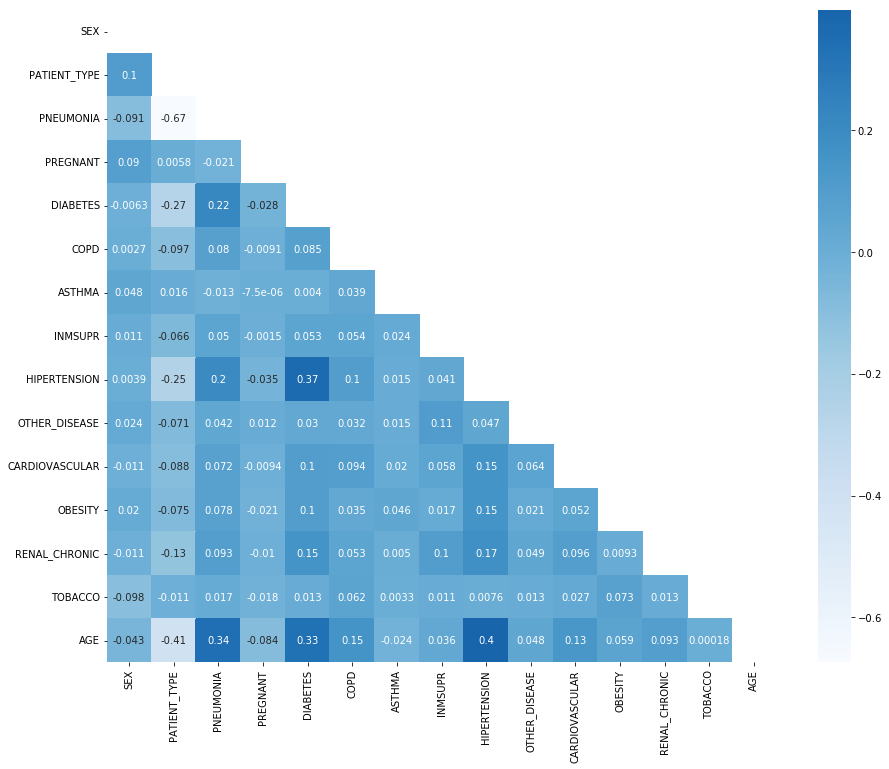

In [47]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df.corr(), center=0, ax=ax, annot=True, mask=np.triu(np.ones_like(df.corr(), dtype=bool)), cmap="Blues");

In [48]:
y=df['PATIENT_TYPE']

In [49]:
y.value_counts()

1.0    279107
0.0    109769
Name: PATIENT_TYPE, dtype: int64

Changing to zero and 1 for the target:

In [50]:
X=df

In [51]:
X

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77
1047934,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1047935,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70
1047936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


In [52]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77
1047934,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1047935,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70
1047936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


In [53]:
df.drop(['PATIENT_TYPE'], axis=1, inplace=True)
X=df

In [54]:
X

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,77
1047934,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1047935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70
1047936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


At this point I took care of the missing values and I don't need to do one hot encoding.
<br>I have my X and y, I can divide in train and test and start trying some models.
<br>But if I want to use KNN first (and I do) I have to scale first, specifically age needs to be scaled.

In [55]:
"""Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that."""

'Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that.'

### Splitting into train and test set

In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [57]:
# Instantiate StandardScaler
scaler = MinMaxScaler()
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert into a DataFrame
X_train = pd.DataFrame(scaled_data_train, columns=X.columns)
X_train.head()

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.619048
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.638095
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.638095


### Preliminary model with Logistic Regression:

A simple model that we can try is Logistic Regression.<br> I works similarly to Linear Regression but it can make predictions on categorical data, splitting continuous intervals into beams.

In [58]:
logreg = LogisticRegression(max_iter=500, random_state=19)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=500, random_state=19)

In [59]:
pred_train_log = logreg.predict(X_train)

We will take a chance here to define a few functions that will help us preview our results.

In [60]:
# defined so that I can use it for test or train
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [61]:
def plot_matrix(labels, preds, cmap=None):
    cm = confusion_matrix(labels, preds)
    # To Normalize
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="OrRd")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [62]:
def model_results(model):
    roc_auc_test=[]
    with plt.style.context('seaborn-talk'):
        print(f'{Fore.BLUE}TRAIN{Style.RESET_ALL}')
        y_preds_train=model.predict(X_train)
        print(classification_report(y_train, y_preds_train))
        print("Accuracy Score Train: {}".format(accuracy_score(y_train, y_preds_train)))
#        print_metrics(y_train, y_preds_train)
        yhat_tr = model.predict_proba(X_train)
        yhat_tr = yhat_tr[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, yhat_tr)
        roc_score_train = roc_auc_score(y_train, yhat_tr)
#        auc_train=auc(fpr, tpr)
        print(f"Train Roc_Auc Score: {roc_score_train :.2%}")
#        print(f"Train AUC Score: {auc_train :.2%}")
        print('Confusion Matrix Train:')
        plot_matrix(y_train, y_preds_train)
        print(f'{Fore.GREEN}TEST{Style.RESET_ALL}')
        y_preds_test=model.predict(X_test)
#        print_metrics(y_test, y_preds_test)
        print(classification_report(y_test, y_preds_test))
        print("Accuracy Score Test: {}".format(accuracy_score(y_test, y_preds_test)))
        yhat_ts = model.predict_proba(X_test)
        yhat_ts = yhat_ts[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat_ts)
        roc_score_test = roc_auc_score(y_test, yhat_ts)
        roc_auc_test.append(roc_score_test)
        print(f"Test Roc_Auc Score: {roc_score_test :.2%}")
#        print(f"Test AUC Score: {auc_test :.2%}")
        print('Confusion Matrix Test:')
        plot_matrix(y_test, y_preds_test)
        plt.show() 

In [216]:
def plot_roc(models):
    colors=['blue', 'green', 'k', 'purple','orange', 'm', 'c', 'red', 'lime' ]
    lines=['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']
    plt.figure(figsize=(10,8))
    for i, j, k in zip(models, lines, colors):
        yhat = i.predict_proba(X_test)
        yhat = yhat[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        plt.plot(fpr, tpr, label=i, alpha=0.6, linestyle=j, color=k, linewidth=1.5)
    plt.plot([0, 1], [0, 1], color='pink', label='No Skill', linewidth=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Test') 
    plt.legend(loc='lower right')
    plt.show()


In [215]:
def compare_roc(model):
    plt.figure(figsize=(10,8))
    yhat_train = model.predict_proba(X_train)
    yhat_train = yhat_train[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, yhat_train)
    plt.plot(fpr, tpr, label='train', alpha=0.6, color='green', linewidth=2)
    yhat_test = model.predict_proba(X_test)
    yhat_test = yhat_test[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
    plt.plot(fpr, tpr, label='test', alpha=0.6, linestyle='dotted', color='b', linewidth=2)
    yhat_log = logreg.predict_proba(X_test)
    yhat_log = yhat_log[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat_log)
    plt.plot(fpr, tpr, label='LogisticRegression', alpha=0.6,linestyle='--', color='r', linewidth=2)
    plt.plot([0, 1], [0, 1], color='pink', linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [65]:
print_metrics(y_train, pred_train_log)

Precision Score: 0.8819533924009156
Recall Score: 0.9512945300671981
Accuracy Score: 0.8736255258745719
F1 Score: 0.9153125746741908


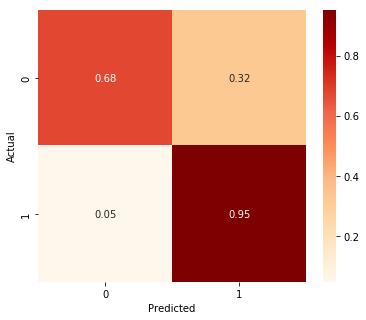

In [66]:
plot_matrix(y_train, pred_train_log)

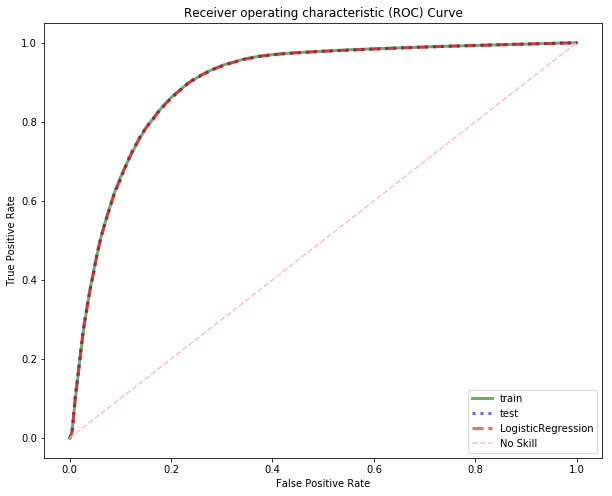

In [187]:
compare_roc(logreg)

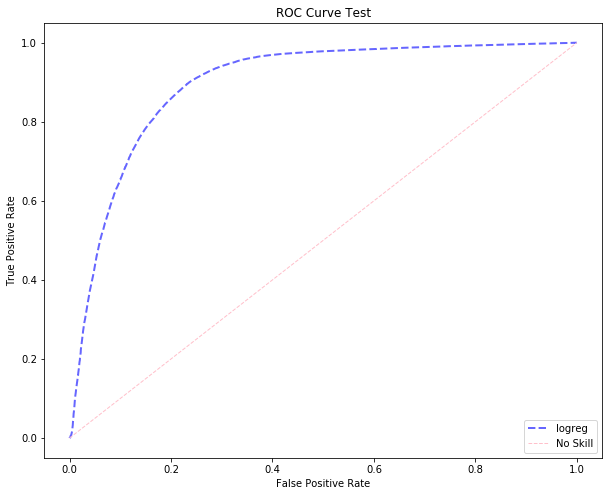

In [173]:
plot_roc([logreg])

In [69]:
#resu_logreg=save_metrics(logreg, y_train, pred_train_log)

In [70]:
#resu_logreg

### Decision tree
The Logistic Regression Model will be kept as our baseline model.
<br>We will try next with a Decision Tree, and see if it performs better.

In [71]:
#Create the tree
DT1 = DecisionTreeClassifier(criterion='entropy', random_state=19)

In [72]:
# fit the tree
DT1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=19)

Results for the Decision Tree Model
TRAIN
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78     82276
         1.0       0.90      0.95      0.92    209381

    accuracy                           0.89    291657
   macro avg       0.88      0.84      0.85    291657
weighted avg       0.88      0.89      0.88    291657

Accuracy Score Train: 0.8865653833098468
Train Roc_Auc Score: 91.65%
Train AUC Score: 91.65%
Confusion Matrix Train:


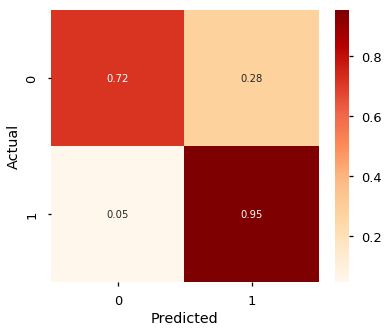

TEST
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75     27493
         1.0       0.88      0.94      0.91     69726

    accuracy                           0.87     97219
   macro avg       0.85      0.81      0.83     97219
weighted avg       0.87      0.87      0.86     97219

Accuracy Score Test: 0.8688013659881298
Test Roc_Auc Score: 87.24%
Test AUC Score: 87.24%
Confusion Matrix Test:


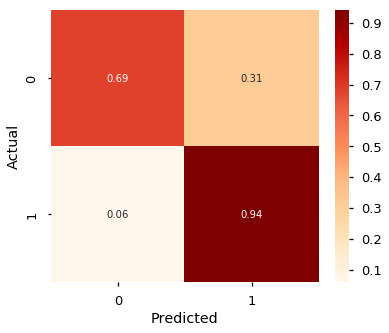

In [73]:
# Evaluate the tree
preds_train_DT1 = DT1.predict(X_train)
print(f'{Fore.RED}Results for the Decision Tree Model')
model_results(DT1)

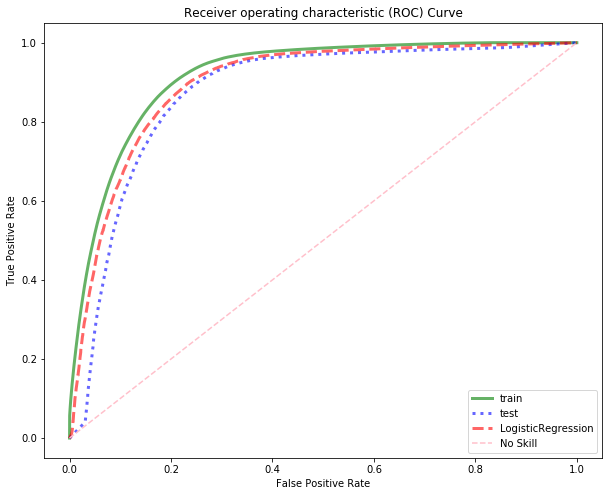

In [188]:
compare_roc(DT1)

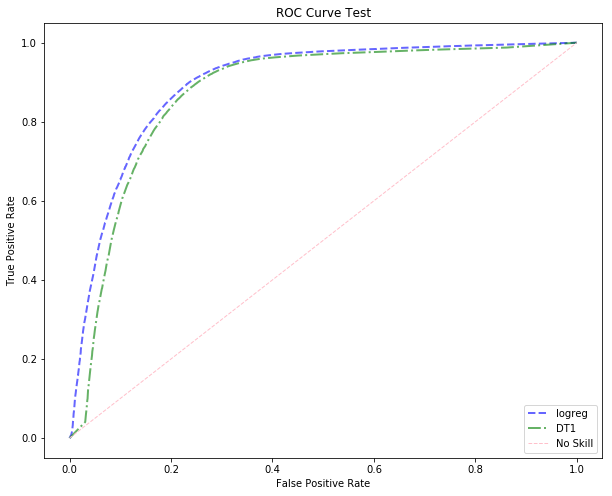

In [189]:
plot_roc([logreg,DT1])

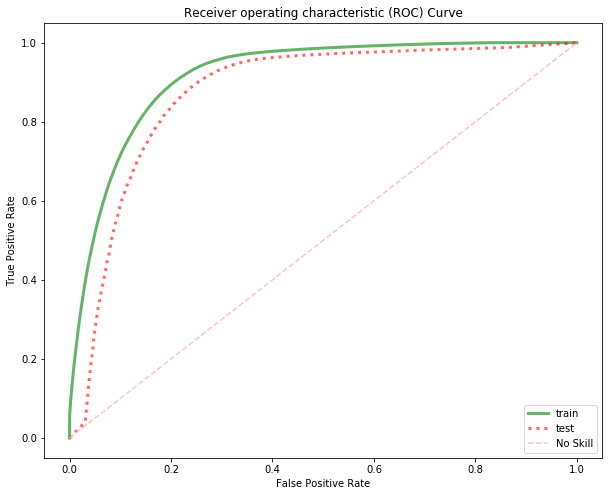

Another feature that we have with decision trees is that we can extract their feature importance.

In [76]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(5,5))
    #not sure why when I add np.sort in front of model feature it changes
    plt.barh(range(n_features), (model.feature_importances_), align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

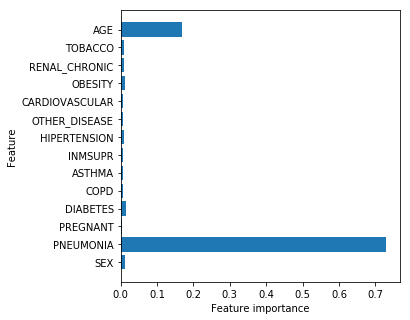

In [77]:
plot_feature_importances(DT1)

In [78]:
#resu_DT1=save_metrics(DT1, y_train, preds_train_DT1)

In [79]:
#resu_DT1

A few more information that we can retrieve about our tree:

In [80]:
print(f'Decision Tree has {DT1.tree_.node_count} nodes with a maximum depth of {DT1.tree_.max_depth}.')
print(f'Model Accuracy for train data: {DT1.score(X_train, y_train)}')

Decision Tree has 22413 nodes with a maximum depth of 31.
Model Accuracy for train data: 0.8865653833098468


This is not so bad as a result. But we have to ekep in mind that because of our class imbalance (80% of the patients returned home and 20% got hospitalized) a baseline model would have an accuracy of 80%.
<br><br>
Also - given our situation I would actually like to have a higher recall than accuracy. With a high recall it means I am getting more false positives because I am decreasing the thershold, but that is what I want most times in 'medical situations', because I would rather have a false positive than a false negative.

### Class Imbalance
<br> One thing we have not considered yet is the fact that the classes of our target (patients sent home vs. patients hospitalized) are not balanced. They are not present equally in our dataset but around 80% of the patients were sent home and only 20% were hospitalized, as we saw from the split of the data for that column.
<br> This means that a very basic model that simply predicts all the patients to be sent home would have an 80% accuracy, that's the baseline.
<br> We have a way to counteract this problem by balancing the classes with a decision tree and that is what we are going to do.

In [81]:
DT_bal = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=19)

In [82]:
DT_bal.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=19)

In [83]:
preds_train_DTbal = DT_bal.predict(X_train)

Results for the Decision Tree Model considering class imbalance
TRAIN
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78     82276
         1.0       0.92      0.90      0.91    209381

    accuracy                           0.87    291657
   macro avg       0.84      0.85      0.84    291657
weighted avg       0.87      0.87      0.87    291657

Accuracy Score Train: 0.8701591252738662
Train Roc_Auc Score: 91.65%
Train AUC Score: 91.65%
Confusion Matrix Train:


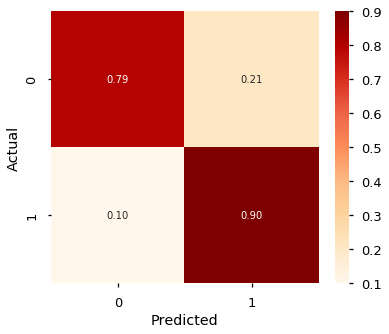

TEST
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74     27493
         1.0       0.90      0.89      0.90     69726

    accuracy                           0.85     97219
   macro avg       0.82      0.82      0.82     97219
weighted avg       0.85      0.85      0.85     97219

Accuracy Score Test: 0.8525493987800739
Test Roc_Auc Score: 87.26%
Test AUC Score: 87.26%
Confusion Matrix Test:


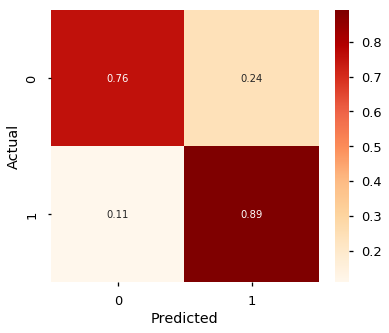

In [84]:
# Evaluate the tree
print(f'{Fore.RED}Results for the Decision Tree Model considering class imbalance')
model_results(DT_bal)

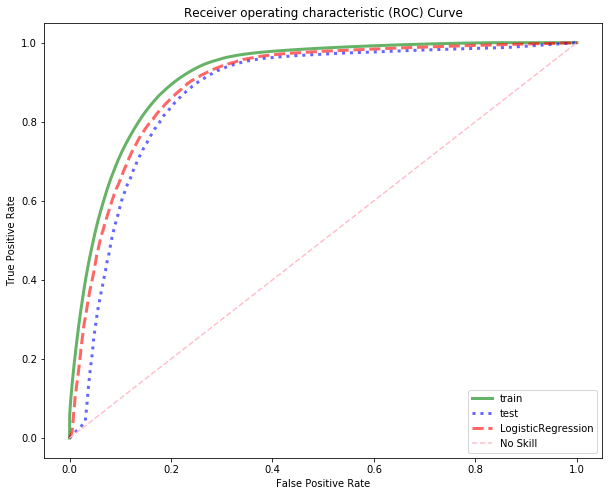

In [190]:
compare_roc(DT_bal)

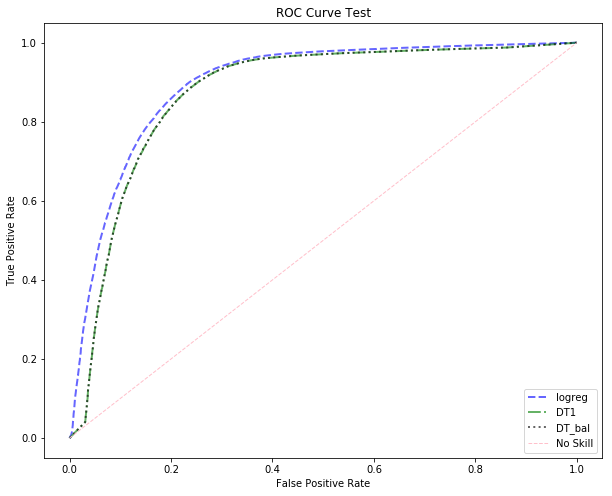

In [191]:
plot_roc([logreg, DT1, DT_bal])

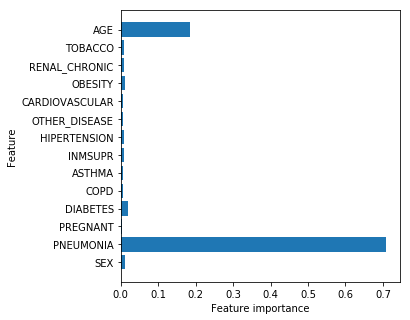

In [87]:
plot_feature_importances(DT_bal)

As we can see from the confusion matrix we started to have more False Positives and the predictions of the majority class (0, people returned home) has decreased. This reflects also in the accuracy score and F1 score.
<br> But on the bright side the predictions for the minority class (1, hospitalized) have improved, with less false negatives and a recall that went from 0.63 to 0.77.
<br> This is a matter of choice for the stakeholder, which model to use. The Decision tree without class imbalance leads to an overall more precise model: less falses overall, negative and positive, more patients categorized correctly.
<br> On the other hand the model that accounts for class imbalance makes more mistakes, has lower accurcay precision and F1 score, but it has overall less false negatives.
<br>Given the specific problem we would recommend staying on the safer side, trying to minimize the false negatives then the false positives, because it would be less of a loss to be prepared for one extra patient that doesn't ultimately need to be hospitalized, rather then not being ready with the equippment for one that actually needs to be.

### PROBABLY NOT DOING THIS GridSearchCV for Decision Tree:

In [88]:
"""param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5, 10, 20],
    'min_samples_split': [0.1, 0.2, 0.5, 0.75],
    'min_samples_leaf':[1,3,5,10]
}

gs_tree = GridSearchCV(DT_bal, param_grid, cv=3)
gs_tree.fit(X_train, y_train)
"""

"param_grid = {\n    'criterion': ['gini', 'entropy'],\n    'max_depth': [None, 1, 5, 10, 20],\n    'min_samples_split': [0.1, 0.2, 0.5, 0.75],\n    'min_samples_leaf':[1,3,5,10]\n}\n\ngs_tree = GridSearchCV(DT_bal, param_grid, cv=3)\ngs_tree.fit(X_train, y_train)\n"

In [89]:
"""gstree_accuracy=gs_tree.best_score_ 
pred_gstree=gs_tree.predict(X_train)
print(f"Testing Accuracy: {gstree_accuracy:.2%}")
print("")
# Mean training score
#dt_gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])
# Mean test score
#dt_gs_testing_score = gs_tree.score(X_test,y_test)
#print(f"Mean Training Score: {dt_gs_training_score :.2%}")
#print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print(f"Best Parameter Combination Found During Grid Search:{gs_tree.best_params_}")
"""

'gstree_accuracy=gs_tree.best_score_ \npred_gstree=gs_tree.predict(X_train)\nprint(f"Testing Accuracy: {gstree_accuracy:.2%}")\nprint("")\n# Mean training score\n#dt_gs_training_score = np.mean(gs_tree.cv_results_[\'mean_train_score\'])\n# Mean test score\n#dt_gs_testing_score = gs_tree.score(X_test,y_test)\n#print(f"Mean Training Score: {dt_gs_training_score :.2%}")\n#print(f"Mean Test Score: {dt_gs_testing_score :.2%}")\nprint(f"Best Parameter Combination Found During Grid Search:{gs_tree.best_params_}")\n'

In [90]:
###model_results(gs_tree)

In [91]:
###resu_gstree=save_metrics(gs_tree, y_train, pred_gstree)

In [92]:
###best_tree=DecisionTreeClassifier(criterion='gini', class_weight='balanced', max_depth=1, min_samples_split=0.1, min_samples_leaf=1, random_state=19)

In [93]:
###best_tree.fit(X_train, y_train)

In [94]:
###preds_best3 = best_tree.predict(X_train)

In [95]:
###print("Results with best Decision Tree considering class imbalance:\n")
###model_results(best_tree)

In [96]:
###resu_best3=save_metrics(best_tree, y_train, preds_best3)

In [97]:
###resu_gstree

In [98]:
###resu_best3

In [99]:
###plot_roc([logreg, DT1, DT_bal, best_tree], y_train)

### Random Forest

In [100]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(random_state=19)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=19)

In [101]:
# Training accuracy score
forest.score(X_train, y_train)

0.8865516685695869

In [102]:
preds_for=forest.predict(X_train)

In [103]:
# This should be the accuracy
#mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))

In [104]:
#mean_rf_cv_score

Results for the Random Forest Model
TRAIN
              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78     82276
         1.0       0.89      0.96      0.92    209381

    accuracy                           0.89    291657
   macro avg       0.88      0.83      0.85    291657
weighted avg       0.89      0.89      0.88    291657

Accuracy Score Train: 0.8865516685695869
Train Roc_Auc Score: 91.42%
Train AUC Score: 91.42%
Confusion Matrix Train:


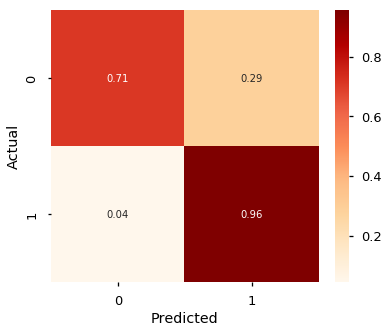

TEST
              precision    recall  f1-score   support

         0.0       0.83      0.68      0.75     27493
         1.0       0.88      0.94      0.91     69726

    accuracy                           0.87     97219
   macro avg       0.86      0.81      0.83     97219
weighted avg       0.87      0.87      0.87     97219

Accuracy Score Test: 0.8700048344459417
Test Roc_Auc Score: 89.04%
Test AUC Score: 89.04%
Confusion Matrix Test:


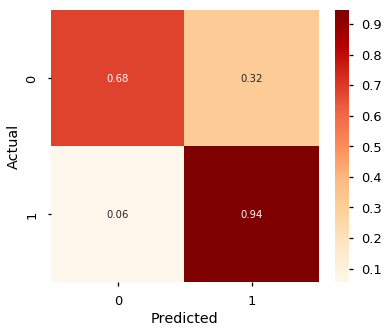

In [105]:
print(f'{Fore.RED}Results for the Random Forest Model')
model_results(forest)

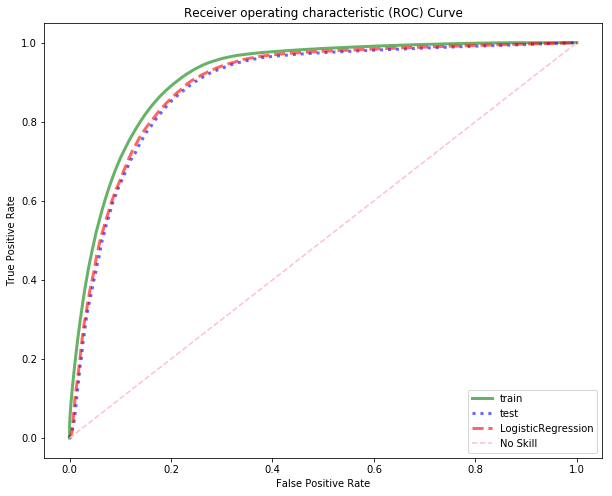

In [192]:
compare_roc(forest)

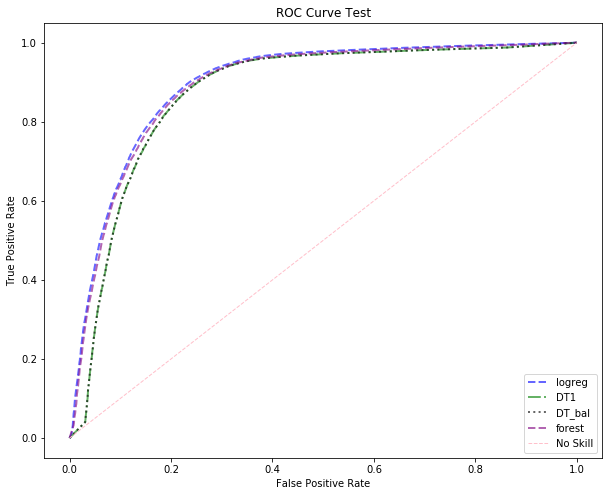

In [193]:
plot_roc([logreg, DT1, DT_bal, forest])

In [108]:
#resu_forest=save_metrics(forest, y_train, preds_for)

### Random Forest class imbalance:
Now accounting for the class imbalance in Random Forest.

In [109]:
forest_bal = RandomForestClassifier(random_state=19, class_weight='balanced')
forest_bal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=19)

In [110]:
# Training accuracy score
forest_bal.score(X_train, y_train)

0.872123761816106

In [111]:
preds_forbal=forest_bal.predict(X_train)

Results for the Random Forest Model considering class imbalance
TRAIN
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78     82276
         1.0       0.92      0.91      0.91    209381

    accuracy                           0.87    291657
   macro avg       0.84      0.85      0.84    291657
weighted avg       0.87      0.87      0.87    291657

Accuracy Score Train: 0.872123761816106
Train Roc_Auc Score: 91.45%
Train AUC Score: 91.45%
Confusion Matrix Train:


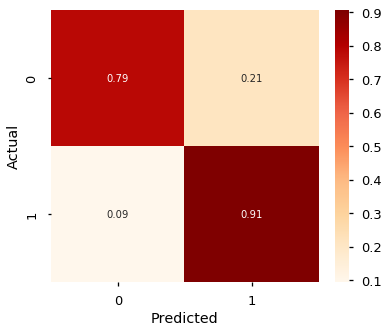

TEST
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75     27493
         1.0       0.90      0.90      0.90     69726

    accuracy                           0.86     97219
   macro avg       0.82      0.82      0.82     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8555632129522007
Test Roc_Auc Score: 88.74%
Test AUC Score: 88.74%
Confusion Matrix Test:


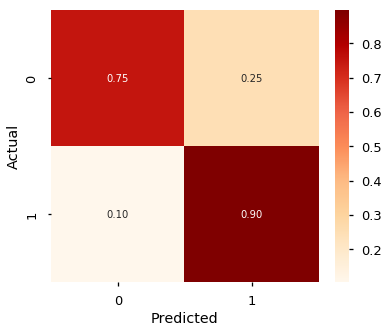

In [112]:
print(f'{Fore.RED}Results for the Random Forest Model considering class imbalance')
model_results(forest_bal)

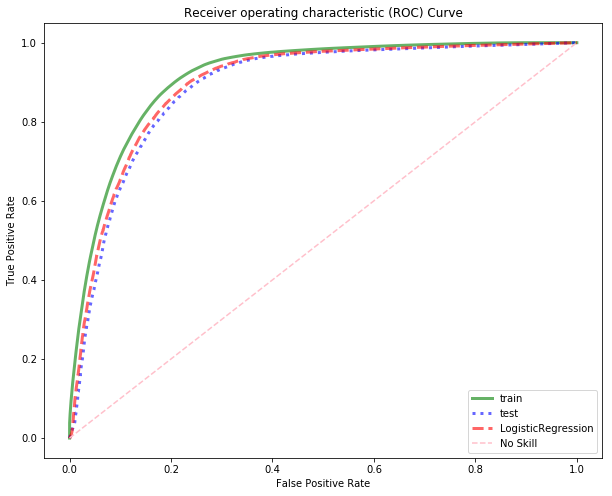

In [194]:
compare_roc(forest_bal)

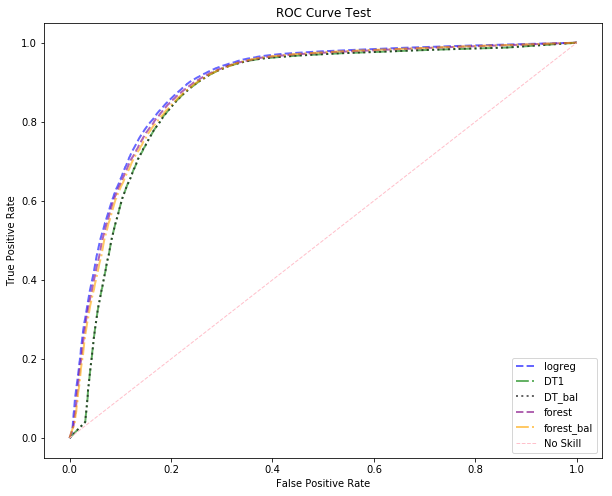

In [195]:
plot_roc([logreg, DT1, DT_bal, forest, forest_bal])

### GridSearchCV for Random Forest:

In [116]:
# create the grid with parameters:

rf_param_grid = { 'n_estimators':[10,30,100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 6, 10, 30],
                 'min_samples_split':[5, 10],
                 'min_samples_leaf':[3, 6]
    
}

In [117]:
""" code with which we ran the GridSearchCV
rf_grid_search = GridSearchCV(forest_bal, rf_param_grid,cv=3)
rf_grid_search.fit(X_train, y_train)"""

' code with which we ran the GridSearchCV\nrf_grid_search = GridSearchCV(forest_bal, rf_param_grid,cv=3)\nrf_grid_search.fit(X_train, y_train)'

Since the model took a very long time to fit I am going to pickle it, to save it for a later rerun without it having to fit again.

In [118]:
filename = 'CVforest.pkl'

In [119]:
""" code with which we saved the model
# save the model to disk

joblib.dump(rf_grid_search, filename)
"""

' code with which we saved the model\n# save the model to disk\n\njoblib.dump(rf_grid_search, filename)\n'

In [120]:
# some time later...

# load the model from disk
loaded_model = joblib.load(filename)

In [121]:
forest_accuracy=loaded_model.best_score_ 
best_params=loaded_model.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 86.63%

Best Parameters:{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}


In [122]:
for_CV1 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='entropy',
                                 max_depth= 6, min_samples_leaf= 6, min_samples_split= 5,n_estimators=10)

In [123]:
for_CV1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=10, random_state=19)

In [124]:
preds_forCV1=for_CV1.predict(X_train)

Results for the Random Forest model with best parameters after First GridSeachCV
TRAIN
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     82276
         1.0       0.90      0.91      0.91    209381

    accuracy                           0.86    291657
   macro avg       0.84      0.83      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8645223670270215
Train Roc_Auc Score: 89.50%
Train AUC Score: 89.50%
Confusion Matrix Train:


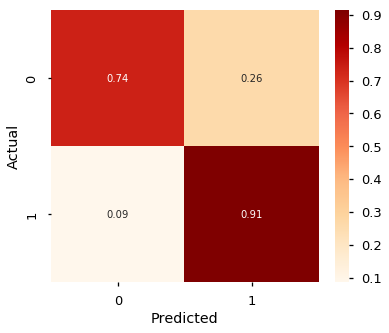

TEST
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     27493
         1.0       0.90      0.91      0.91     69726

    accuracy                           0.86     97219
   macro avg       0.83      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8636274802250589
Test Roc_Auc Score: 89.44%
Test AUC Score: 89.44%
Confusion Matrix Test:


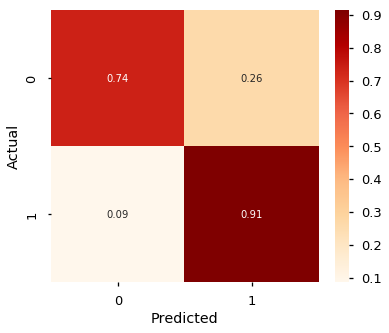

In [125]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after First GridSeachCV')
model_results(for_CV1)

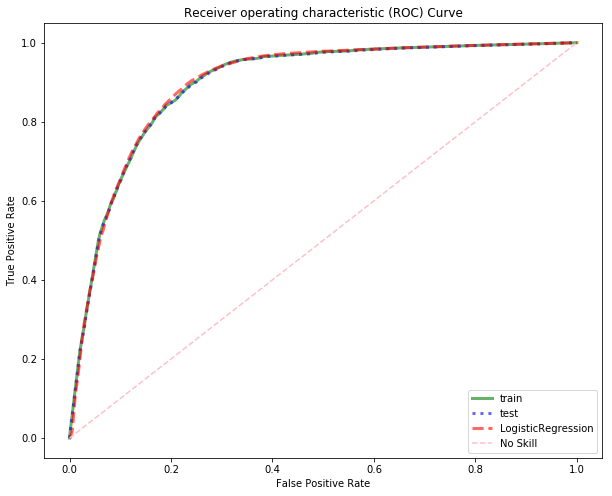

In [196]:
compare_roc(for_CV1)

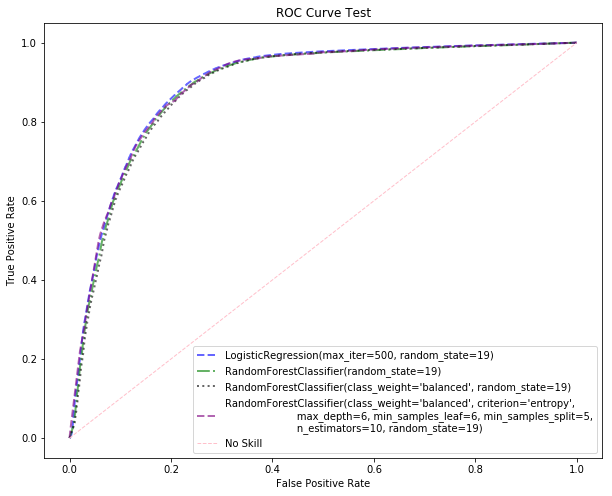

In [207]:
plot_roc([logreg, forest, forest_bal, for_CV1])

In [128]:
#model_results(loaded_model) I do not think this makes sense but lets hear from Eva

In [129]:
rf_param_grid2 = { 'n_estimators':[20,30,40],
                 'criterion': ['gini'],
                 'max_depth':[None],
                 'min_samples_split':[3,5],
                 'min_samples_leaf':[5, 10, 20]
    
}

In [130]:
"""Code with which we ran the second grid search
rf_grid_search2 = GridSearchCV(forest_bal, rf_param_grid2,cv=3)
rf_grid_search2.fit(X_train, y_train)"""

'Code with which we ran the second grid search\nrf_grid_search2 = GridSearchCV(forest_bal, rf_param_grid2,cv=3)\nrf_grid_search2.fit(X_train, y_train)'

In [131]:
filename2 = 'forGrid2.pkl'

In [132]:
""" code with which we saved the model
# save the model to disk

joblib.dump(rf_grid_search2, filename2)
"""

' code with which we saved the model\n# save the model to disk\n\njoblib.dump(rf_grid_search2, filename2)\n'

In [133]:
# some time later...

# load the model from disk
loaded_model2 = joblib.load(filename2)

In [134]:
forest_accuracy=loaded_model2.best_score_ 
best_params=loaded_model2.best_params_

In [135]:
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 85.66%

Best Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 30}


In [136]:
for_CV2 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='gini', max_depth= None, 
                                 min_samples_leaf= 5, min_samples_split= 3, n_estimators=30)

In [137]:
for_CV2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=3, n_estimators=30, random_state=19)

In [138]:
preds_forCV2=for_CV2.predict(X_train)

Results for the Random Forest model with best parameters after Second GridSeachCV
TRAIN
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76     82276
         1.0       0.91      0.89      0.90    209381

    accuracy                           0.86    291657
   macro avg       0.83      0.84      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8622422914588026
Train Roc_Auc Score: 90.67%
Train AUC Score: 90.67%
Confusion Matrix Train:


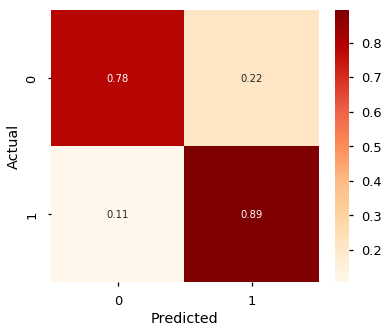

TEST
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76     27493
         1.0       0.91      0.89      0.90     69726

    accuracy                           0.86     97219
   macro avg       0.82      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8585564550139376
Test Roc_Auc Score: 89.87%
Test AUC Score: 89.87%
Confusion Matrix Test:


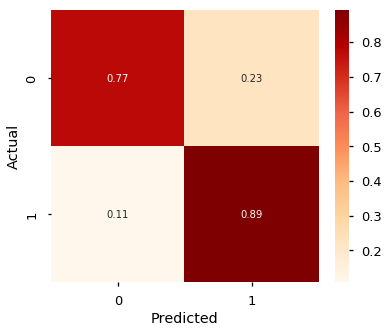

In [139]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after Second GridSeachCV')
model_results(for_CV2)

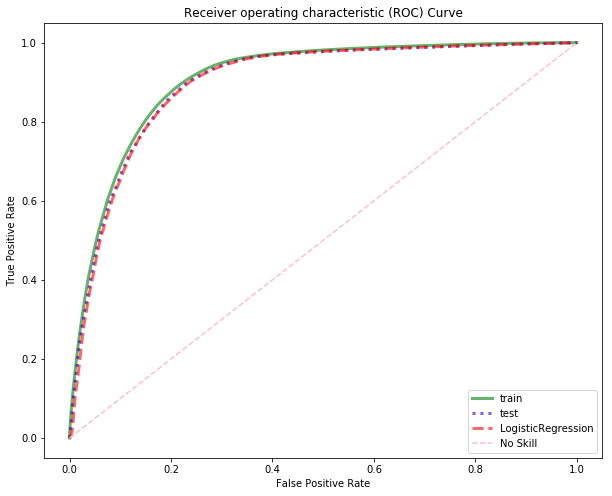

In [200]:
compare_roc(for_CV2)

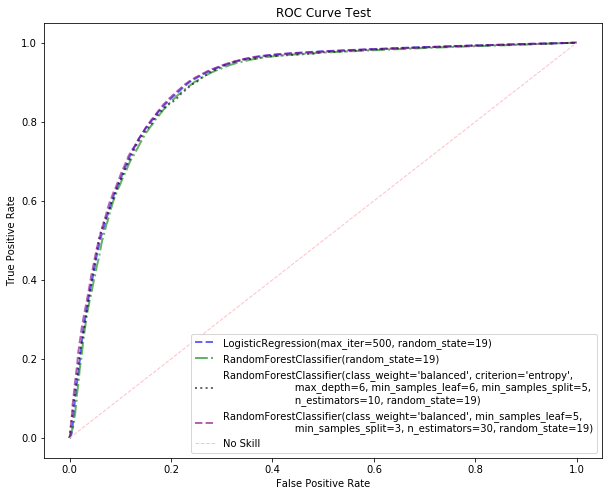

In [208]:
plot_roc([logreg, forest, for_CV1, for_CV2])

In [142]:
rf_param_grid3 = { 'n_estimators':[10, 15],
                 'criterion': ['entropy'],
                 'max_depth': [None,3,6],
                 'min_samples_split':[1,3,5],
                 'min_samples_leaf':[6, 10, 20]
    
}

In [143]:
"""Code with which we ran the third gridsearch
rf_grid_search3 = GridSearchCV(forest_bal, rf_param_grid,cv=3)
rf_grid_search3.fit(X_train, y_train)"""

'Code with which we ran the third gridsearch\nrf_grid_search3 = GridSearchCV(forest_bal, rf_param_grid,cv=3)\nrf_grid_search3.fit(X_train, y_train)'

In [144]:
filename3 = 'CVforest3.pkl'

In [145]:
"""Code with which we saved the third gridserch
joblib.dump(rf_grid_search3, filename3)
"""

'Code with which we saved the third gridserch\njoblib.dump(rf_grid_search3, filename3)\n'

In [146]:
# some time later...

# load the model from disk
loaded_model3 = joblib.load(filename3)

In [147]:
forest_accuracy=loaded_model3.best_score_ 
best_params=loaded_model3.best_params_
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 86.63%

Best Parameters:{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}


In [148]:
for_CV3 = RandomForestClassifier(random_state=19,class_weight='balanced',criterion='entropy', max_depth= 6,
                                 min_samples_leaf= 6, min_samples_split=5, n_estimators= 10)

In [149]:
for_CV3.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=10, random_state=19)

In [150]:
preds_forCV3=for_CV3.predict(X_train)

Results for the Random Forest model with best parameters after Third GridSeachCV
TRAIN
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     82276
         1.0       0.90      0.91      0.91    209381

    accuracy                           0.86    291657
   macro avg       0.84      0.83      0.83    291657
weighted avg       0.86      0.86      0.86    291657

Accuracy Score Train: 0.8645223670270215
Train Roc_Auc Score: 89.50%
Train AUC Score: 89.50%
Confusion Matrix Train:


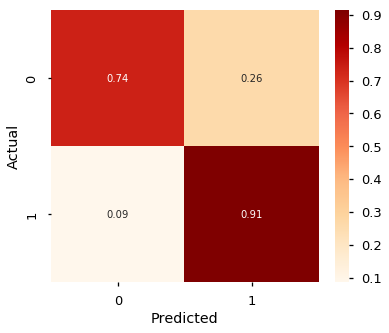

TEST
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     27493
         1.0       0.90      0.91      0.91     69726

    accuracy                           0.86     97219
   macro avg       0.83      0.83      0.83     97219
weighted avg       0.86      0.86      0.86     97219

Accuracy Score Test: 0.8636274802250589
Test Roc_Auc Score: 89.44%
Test AUC Score: 89.44%
Confusion Matrix Test:


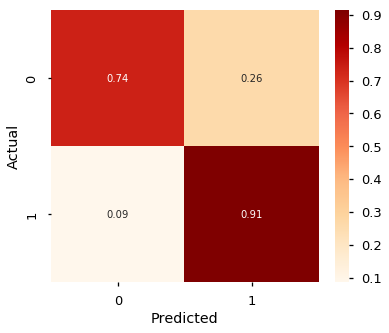

In [209]:
print(f'{Fore.RED}Results for the Random Forest model with best parameters after Third GridSeachCV')
model_results(for_CV3)

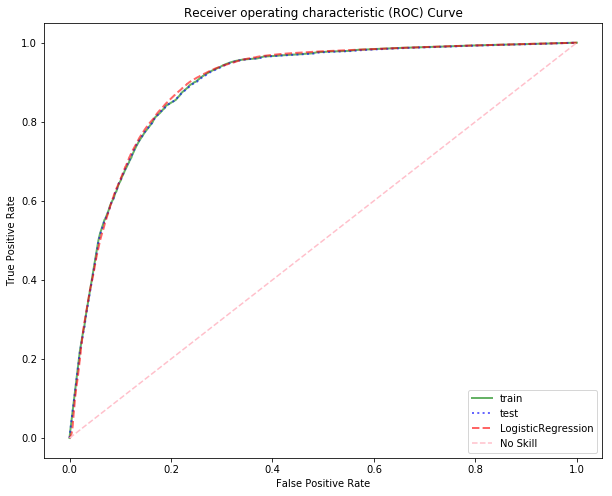

In [217]:
compare_roc(for_CV3)

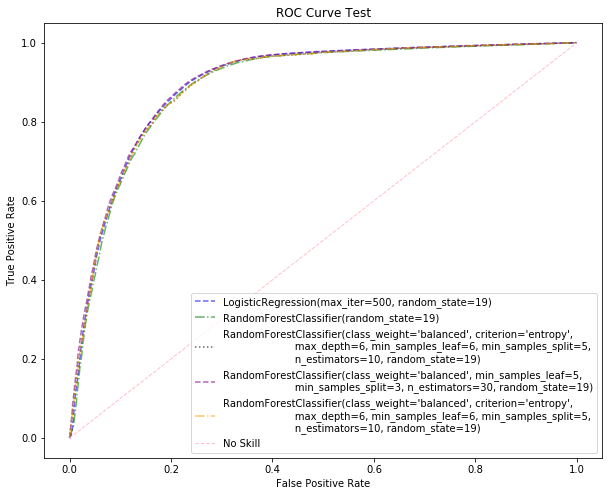

In [218]:
plot_roc([logreg,forest, for_CV1, for_CV2, for_CV3])

### XGBooster

In [229]:
# Instantiate the encoder
encoder = LabelEncoder()

# Fit and transform the training data
encoder.fit(y_train)
y_train=encoder.transform(y_train)
# Transform the test data
y_test=encoder.transform(y_test)
train_x = train_df.values
test_x = test_df.values

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [231]:
X_train= X_train.values
X_test = X_test.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [227]:
# Instantiate XGBClassifier
xgb_model = xgb.XGBClassifier(random_state=19)

# Fit XGBClassifier
xgb_model.fit(X_train, y_train)

# Predict on training and test sets
xgb_preds_train = xgb_model.predict(X_train)
#xgb_preds_test = xgb_model.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, xgb_preds_train)
#est_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 87.58%


In [237]:
xgb_model.score(X_test, y_test)

ValueError: feature_names mismatch: ['SEX', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'AGE'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13']
expected COPD, OTHER_DISEASE, DIABETES, PNEUMONIA, OBESITY, AGE, INMSUPR, ASTHMA, SEX, CARDIOVASCULAR, PREGNANT, TOBACCO, HIPERTENSION, RENAL_CHRONIC in input data
training data did not have the following fields: f10, f5, f6, f9, f4, f2, f3, f1, f8, f11, f12, f7, f0, f13

In [235]:
y_test = y_test[X_train.columns]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Results for the XGB model
TRAIN
              precision    recall  f1-score   support

           0       0.85      0.68      0.76     82276
           1       0.88      0.95      0.92    209381

    accuracy                           0.88    291657
   macro avg       0.87      0.82      0.84    291657
weighted avg       0.87      0.88      0.87    291657

Accuracy Score Train: 0.8758404564265558
Train Roc_Auc Score: 90.12%
Train AUC Score: 90.12%
Confusion Matrix Train:


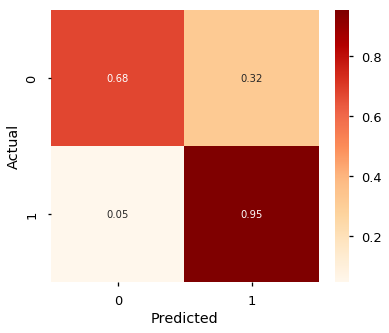

TEST


ValueError: feature_names mismatch: ['SEX', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'AGE'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13']
expected COPD, OTHER_DISEASE, DIABETES, PNEUMONIA, OBESITY, AGE, INMSUPR, ASTHMA, SEX, CARDIOVASCULAR, PREGNANT, TOBACCO, HIPERTENSION, RENAL_CHRONIC in input data
training data did not have the following fields: f10, f5, f6, f9, f4, f2, f3, f1, f8, f11, f12, f7, f0, f13

In [228]:
print(f'{Fore.RED}Results for the XGB model')
model_results(xgb_model)

In [ ]:
print(f'{Fore.RED}Results for the XGB model Train')

print_metrics(y_train, xgb_preds_train)
plot_matrix(y_train, xgb_preds_train)

print(f'{Fore.RED}Results for the XGB model Test')
print_metrics(y_test, xgb_preds_test)
plot_matrix(y_test, xgb_preds_test)

In [ ]:
compare_roc(xgb_model)

In [ ]:
plot_roc([logreg, forest, for_CV2, xgb_model])

### AdaBoost - adaptive boosting:
<br> Boosting is a way to improve the models
<br> Adaboost is one way to do boosting

In [ ]:
ada = AdaBoostRegressor(random_state=19)
model.fit(X_train, y_train)
model.predict(X_train)

model.score(X_test,y_test)

In [ ]:
model = AdaBoostRegressor(
            base_estimator = DecisionTreeRegressor(), 
            n_estimators = 1000,
            random_state= 19
)

model.fit(X_train, y_train)
model.score(X_test,y_test)

In [249]:
cross_val_score(model, X_train, y_train, cv=5)

array([0.433652  , 0.37240252, 0.35990812, 0.4308424 , 0.43395087])

In [246]:
gs = GridSearchCV(estimator=model,
                 param_grid={
                     'n_estimators': [25, 50, 100],
                     'loss': ['linear', 'square']
                 }, cv=5)

In [247]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                                         n_estimators=200, random_state=19),
             param_grid={'loss': ['linear', 'square'],
                         'n_estimators': [25, 50, 100]})

In [248]:
gs.best_params_

{'loss': 'linear', 'n_estimators': 25}

In [252]:
ada = AdaBoostRegressor(
            base_estimator = DecisionTreeRegressor(max_depth=6), 
            n_estimators = 25,
            random_state= 19, loss='linear'
)

ada.fit(X_train, y_train)
ada.score(X_test,y_test)

0.4324712126421595

### Gradient Boosting

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train, y_train)

In [ ]:
gbc.score(X_test, y_test)

In [ ]:
recall_score(y_test, gbc.predict(X_test))

In [ ]:
model_results(gbc)

# To draw some conclusions:
Now in order to draw some conclusions let us look at the results of the different models together and we will plot the ROC curve for all the different models we saw.
<br>Once we can identify the best model we can see what the most important features were for that model.

In [ ]:
models=[DT1, DT_bal, logreg, forest, best_forest, best_forest_bal, xgb_model]

In [ ]:
recalls=[]
F1s=[]
for i in (models):
    preds=i.predict(X_test)
    recalls.append(recall_score(y_test, preds))
    F1s.append(f1_score(y_test, preds))

In [238]:
### SORT THIS DF BY SOMETHING

results=pd.DataFrame([])
results['model']=models
results['recall']=recalls
results['F1']=F1s
results['AUC']=roc_auc_test
results

NameError: name 'models' is not defined

In [ ]:
### Here I would compare just the 2/3 best confusion matrices
#for i in (models):
#    preds=i.predict(X_train)
#    print(f"{Fore.BLUE} Model {Style.RESET_ALL}", i)
#    plot_matrix(y_train, preds)

In [ ]:
models_fi=[logreg, DT1, DT_bal, forest, forest_bal,for_CV1, for_CV2, for_CV3, xgb_model]

In [ ]:
models_b=[forest_bal, for_CV2, xgb_model]

In [ ]:
##Here if I want I could create a df with all the feature importances. But maybe not necessary.
# Feature Importance
feat=[]
imp=[]
mod=[]
for i in models_b:
    feature_used = df.columns
    for fi, feature in zip(i.feature_importances_, feature_used):
        imp.append(fi)
        feat.append(feature)

In [ ]:
feat_imp=pd.DataFrame([])
feat_imp['model']=mod
feat_imp['features']=feat
feat_imp['importance']=imp

feat_imp.head()

In [ ]:
feat_imp['model'][0:13]='Forest Balanced'
feat_imp['model'][13:26]='Forest CV2'
feat_imp['model'][26:]='XGB'

In [ ]:
plt.style.use('seaborn-poster')
#plt.figure(figsize=(30,15))
#features = sns.load_dataset("feat_imp")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=feat_imp, kind="bar",
    x="features", y="importance", hue="model",aspect=20/15
#    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_axis_labels("", "Feature Importance")
g.fig.set_figwidth(20)
g.fig.set_figheight(10)
g.set_xticklabels(labels=feat, rotation=90);

From what we can observe the five most important features in our selection overall for the models are:
    Pneumonia, Age, Diabetes, Renal Chronic, Hypertension and Sex?
    IDK I have to study this.

I should take the best model,
look at the list of Most Relevant Features,
and then study them.
For age, the only numeric one, I can divide it in bins and then plot for each bin the number of patients hospitalized.
To get a sense of what patients are more at risk.
For the other factors just say Drs can take care of those factors more, CDC could start campaigns and study more in depth people with those diseases.